In [1]:
%load_ext autoreload
%autoreload 2

# Import libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle,time
from scipy.constants import c
from LumericalLibraries.mode_solutions import mode_sol
from LumericalLibraries.overlap_calc import Overlap_calc
from itertools import product

# Define functions

In [3]:
def calc_peak_power(avg,rep,width):
    ''' Caclulates peak power from average power rep rate and pulse width '''
    pulse_energy = avg/rep

    return pulse_energy/width
def effective_length(pulse_width1,pulse_width2,beta1):

    ''' Caclulates the effective interaction length of 2 pulses with given pulse widths and group velocities '''

    # prefactor  = np.sqrt(2)/(0.441271*np.pi*2)
    prefactor  = (4*np.sqrt(np.log(2)))/(0.441271*np.pi*2)
    numerator = np.sqrt(pulse_width1**2 + pulse_width2**2)
    denomenator = abs(beta1[0] - beta1[1])

    return (prefactor * numerator)/denomenator

def phase_shift(L,ng_p,ng_s,overlap,power,wav):
    
    n2 = 2.4e-19 #nonlinear refractive index of silicon nitride
    n0 = 1.984675 #refractive index of silicon nitride
    
    prefactor = (4*np.pi*n2)/wav
    ns = ((ng_p * ng_s)/n0**2)

    return prefactor*ns* overlap * power * L

# Simulation parameters

Note that the general simulation parameters are also defined within the Overlap_calc class - definitely bad coding form so feel free to change that.

In [6]:
'''silicon nitride'''

simulation_params_nitride = {
'width': 2e-6,
'height':330e-9,
'top_cladding_thickness': 0.75e-6,
'bottom_cladding_thickness':3.3e-6,
'Mode_resolution':100,
'material_wg': "SiN (Silicon Nitride) - MuensterSpecs",
'material_clad': "HSQ - Munster spec"
}

start_wavelength = 1.555e-6
stop_wavelength = 1.56e-6
points = 20
step = (stop_wavelength-start_wavelength) / (points-1)


general_params = {
"wavelength" : 1.55e-6,
"start_wavelength":start_wavelength,
"stop_wavelength":stop_wavelength,
"N_points_Disp":points,
"d_wavelength" :step,
"Lc" : 1e-6,
"mesh_dx" : 0.1e-6,
"mesh_dy" : 0.1e-6,
"substrate_height": 2e-6,
"num_TE" : 4
} 


# Example sweeps just in MODE

Two example sweeps. First we will perform a sweep of the waveguide width but always at a fixed wavelength, and plot the effective indices of the transverse electric modes. Second we will perform a wavelength sweep for a fixed geometry and again plot the effective index of the transverse electric modes. The example plots have been performed with a large mesh so might not be too accurate.

In [5]:
simulation_params = dict()
simulation_params.update(simulation_params_nitride)
simulation_params.update(general_params)
MODE = mode_sol(simulation_params, hide = False, close = False, mode = 'TE')

Initialising MODE instance...
Inputting simulation parameters...
Fitting material parameters...
Initialisation complete


In [14]:
'''width sweep'''
param_sweep = {
    'parameter':'width',
    'parameter_start':1.3e-6,
    'parameter_end':5e-6,
    'steps':5
}
neff_array = MODE.parameter_sweep(param_sweep)

Performing parameter sweep
Sweep complete


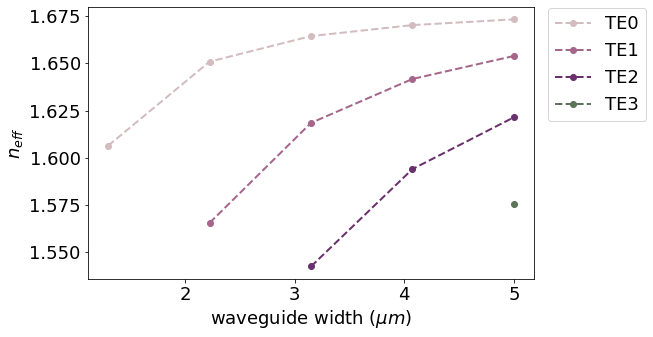

In [19]:
width_array = np.linspace(param_sweep['parameter_start'],param_sweep['parameter_end'],param_sweep['steps'])

#rearrange neff array into separate transverse modes

neff_plot_arrays = [[] for _ in range(MODE.simulation_parameters['num_TE'])]

for neff in neff_array:
    '''iterate through each wg width'''
    for i,n in enumerate(neff):
        '''iterate through guided modes'''    
        neff_plot_arrays[i].append(n)
        
    for j in range(len(neff_plot_arrays)-i-1):
        neff_plot_arrays[i+j+1].append(None)

              
'''Plot'''
plt.rcParams.update({'font.size':18})
fig,ax = plt.subplots(figsize = (8,5))
ax.set_xlabel(r'waveguide width ($\mu m$)')
ax.set_ylabel(r'$n_{eff}$')
colours = ["#d3bcc0","#a5668b","#69306d","#5c7457","#467599","#1d3354",'#5A7D7C']

for j,neff in enumerate(neff_plot_arrays):
    
    ax.plot(width_array*1e6,neff,'--o',lw = 2,label = f'TE{j}',color = colours[j])

ax.legend(bbox_to_anchor = (1.01,1.03))
plt.show()

In [20]:
'''keep wg width to the widest from previous sweep to maximise supported modes'''

neff_array,vg_array,D_array,wavs = MODE.freq_sweep()

Performing frequency sweep
Sweep complete


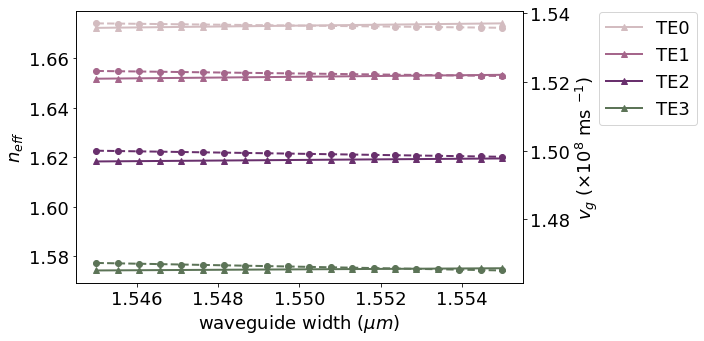

In [27]:
plt.rcParams.update({'font.size':18})
fig,ax = plt.subplots(figsize = (8,5))
ax.set_xlabel(r'waveguide width ($\mu m$)')
ax.set_ylabel(r'$n_{eff}$')
ax2 = ax.twinx()
ax2.set_ylabel(r'$v_g$ ($\times 10^{8}$ ms ${}^{-1}$) ')

colours = ["#d3bcc0","#a5668b","#69306d","#5c7457","#467599","#1d3354",'#5A7D7C']

for j,(neff,vg) in enumerate(zip(neff_array,vg_array)):
    
    ax.plot(wavs*1e6,neff,'--o',lw = 2,label = f'TE{j}',color = colours[j])
    ax2.plot(wavs*1e6,vg*1e-8,'-^',lw = 2,label = f'TE{j}',color = colours[j])

ax2.legend(bbox_to_anchor = (1.15,1.03))
plt.show()

# Overlap calculations

Getting mode info...


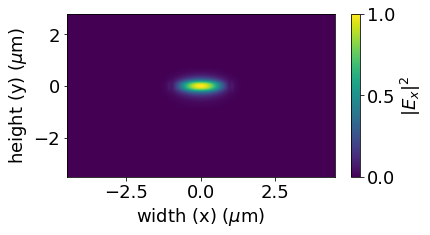

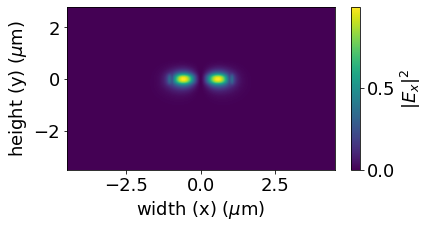

<Figure size 432x288 with 0 Axes>

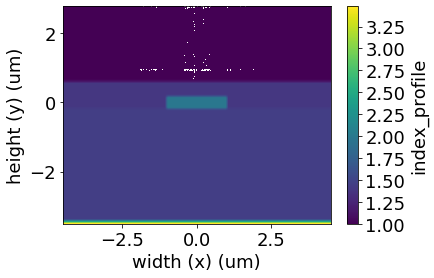

In [16]:
mode_indices = [0,1]

OL = Overlap_calc(simulation_params_nitride,mode_indices)
nonlinear_overlap,TE0_overlap,TE1_overlap,lin_ols = OL.NL_overlap()

In [15]:
print(f'NL overlap = {nonlinear_overlap}')
print(f'Aeff = {(1/nonlinear_overlap) * 1e12} um^2')
print(f'relative overlap with TE0 = {nonlinear_overlap/TE0_overlap}')
print(f'individual Aeffs: TE0 = {(1/TE0_overlap)* 1e12} um^2,  TE1 = {(1/TE1_overlap)* 1e12} um^2')
print(f'linear overlaps = {lin_ols}')

NL overlap = 454439139443.08997
Aeff = 2.200514685476891 um^2
relative overlap with TE0 = 0.5718342158189089
individual Aeffs: TE0 = 1.2583295895676707 um^2,  TE1 = 1.656831693529984 um^2
linear overlaps = [1.0000000000000004, 0.9999999999999993, 7.680868144906794e-29]


# Phase shift 

Example phase shift calculation for a single waveguide geometry. Sweep average power.

In [4]:
'''laser parameters'''

rep_rate = 50e6
c = 3e8
lambda_signal = 1555e-9
lambda_pump = 1560e-9

signal_pulse_width = 5e-12
pump_pulse_width = 4e-12

average_power_array = np.linspace(0,20,10)*1e-3

'''Switch geometry'''

width = 2e-6
length = 3e-2


Initialising MODE instance...
Inputting simulation parameters...
Fitting material parameters...
Initialisation complete
Getting mode info...


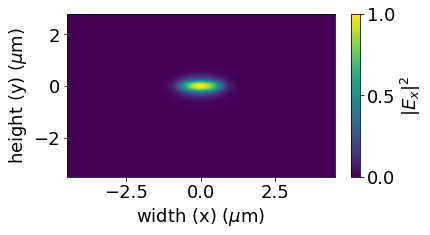

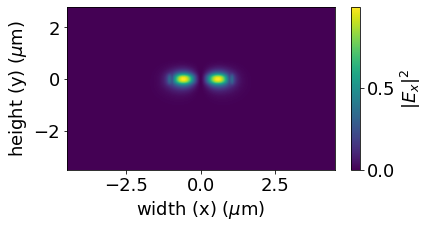

<Figure size 432x288 with 0 Axes>

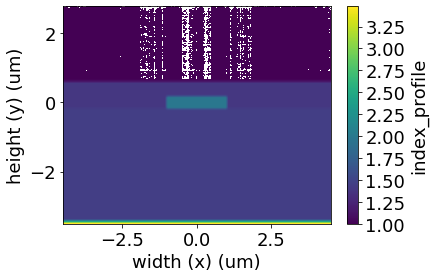

In [10]:
'''Get Lumerical data'''

mode_indices = [0,1]
simulation_params_nitride['width']=width
OL = Overlap_calc(simulation_params_nitride,mode_indices)
nonlinear_overlap,TE0_overlap,TE1_overlap,lin_ols = OL.NL_overlap(freq_sweep = 1)
vg_array = OL.vgs


In [15]:

beta1_pump = 1/vg_array[1][-1]
beta1_signal = 1/vg_array[0][0]

ngp = c/vg_array[1][-1]
ngs = c/vg_array[0][0]

Leff = effective_length(pump_pulse_width,signal_pulse_width,[beta1_signal,beta1_pump])

acc_L = min([length,Leff])

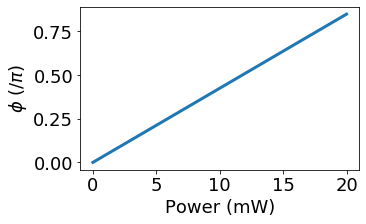

In [16]:
phase_shifts = []

fig,ax = plt.subplots(figsize = (5,3))
ax.set_xlabel(r'Power (mW)')
ax.set_ylabel(r'$\phi$ (/$\pi$)')

for avg_power in average_power_array:
    
    peak_power = calc_peak_power(avg_power,rep_rate,pump_pulse_width)
    
    PS = phase_shift(acc_L,ngp,ngs,nonlinear_overlap,peak_power,lambda_signal)/np.pi
    
    phase_shifts.append(PS)
    
ax.plot(average_power_array*1e3,phase_shifts,'-',lw = 3)
    